In [95]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import os

import torch
import cv2
import shutil
import numpy as np
from PIL import Image, ImageDraw
from ultralytics import YOLO

from utils.utils import list_file_r, copy_image_to_sub_dir, create_yolo_annotation_from_mask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# can install package here if needed
import sys
package_name = 'pillow' # enter package name here
!{sys.executable} -m pip install {package_name}

In [96]:
mask_data_path = 'datasets/CF_simulation/mask/real/base'
annotation_dst = 'datasets/CF_simulation/labels/real/base'
mask_pfs = list_file_r(mask_data_path, extension=['.tif', '.bmp', '.jpg', '.png'])
create_yolo_annotation_from_mask(mask=mask_data_path,out=annotation_dst)

In [ ]:
# export YOLO segmentation format to a single COCO format json file
from utils.formating import yolo_to_coco
ann_folder = 'D:/xie/Vision/mcp_yolo/datasets/CF_simulation/labels/augmented/train'
img_folder = 'D:/xie/Vision/mcp_yolo/datasets/CF_simulation/images/augmented/train'
yolo_to_coco(folder=ann_folder, img_folder=img_folder)

In [3]:
# randomly select images for train/validation set
if True:
    image_data_path = 'datasets/CF_simulation/images/real/base'
    annotation_path = 'datasets/CF_simulation/labels/real/base'
    if not os.path.exists(image_data_path):
        os.makedirs(image_data_path)
    if not os.path.exists(annotation_path):
        os.makedirs(annotation_path)
    image_pfs = list_file_r(path=image_data_path, extension=['.tif'])

    rng = np.random.default_rng(seed=12345)
    sample_size, validation_ratio = len(image_pfs), 0.1

    selected_image_pfs = rng.choice(image_pfs, size=sample_size, replace=False)
    validation_image_pfs = selected_image_pfs[:int(sample_size*validation_ratio)]
    training_image_pfs = selected_image_pfs[int(sample_size*validation_ratio):]


    copy_image_to_sub_dir(training_image_pfs, sub_dir='train') 
    copy_image_to_sub_dir(validation_image_pfs, sub_dir='val')
    

In [3]:
torch.cuda.empty_cache()
arguments={
    'epochs':100,
    'project': 'RDA',
    'name':'largeData_large_640p_100e',
    'imgsz':640,
    #'epochs':20,
}
model = YOLO('yolov8l-seg.yaml')
results = model.train(data='train_augmented_RDA.yaml', **arguments)


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

train: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\line\RDA_large\train... 18314 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18314/18314 [00:45<00:00, 401.81it/s]


train: New cache created: D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\line\RDA_large\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\line\RDA_large\val... 2034 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2034/2034 [00:05<00:00, 344.10it/s]


val: New cache created: D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\line\RDA_large\val.cache
Plotting labels to RDA\largeData_large_640p_100e\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.1G      3.427      5.388      2.805      3.751        193        640: 100%|██████████| 1145/1145 [07:28<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:27<00:00,  2.34it/s]


                   all       2034      16850        0.3      0.322      0.207     0.0783     0.0361      0.064     0.0071    0.00127

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.3G      1.846      2.352      1.342      2.125        200        640: 100%|██████████| 1145/1145 [07:22<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.50it/s]


                   all       2034      16850       0.86      0.753      0.833      0.456      0.541      0.474       0.32     0.0953

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.4G      1.198      1.622     0.8685      1.522        209        640: 100%|██████████| 1145/1145 [07:21<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.56it/s]


                   all       2034      16850      0.917      0.817      0.884       0.59      0.763       0.68      0.634      0.282

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.1G     0.9629      1.272     0.6929      1.286        175        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.52it/s]


                   all       2034      16850      0.929      0.822      0.898      0.653       0.85      0.754      0.768      0.381

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.3G     0.8303       1.09     0.5952      1.184        201        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]


                   all       2034      16850      0.943      0.842      0.914      0.725       0.89      0.799      0.837      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.5G     0.7498     0.9787     0.5401      1.134        248        640: 100%|██████████| 1145/1145 [07:21<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.51it/s]


                   all       2034      16850       0.95      0.859      0.918      0.753      0.892      0.811      0.839      0.521

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.4G     0.6963     0.9166      0.505      1.103        191        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]


                   all       2034      16850      0.945      0.881      0.927      0.795      0.921      0.849      0.881      0.603

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.5G     0.6591     0.8607     0.4779      1.078        150        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]


                   all       2034      16850       0.96      0.866      0.929      0.801      0.941      0.839      0.895      0.614

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.3G     0.6258     0.8302     0.4575      1.062        200        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:25<00:00,  2.53it/s]


                   all       2034      16850      0.954       0.89      0.934      0.819      0.939      0.853      0.897      0.652

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.2G     0.6063     0.7956     0.4438      1.048        144        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.58it/s]


                   all       2034      16850      0.966      0.884      0.931      0.828      0.958      0.874      0.915      0.672

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      12.3G     0.5854     0.7713     0.4298      1.036        213        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.963      0.887      0.939      0.838       0.95      0.868      0.914      0.684



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      12.2G     0.5663     0.7448     0.4143      1.024        134        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.57it/s]


                   all       2034      16850      0.971        0.9      0.933      0.844      0.957      0.885      0.916      0.696

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      12.2G     0.5582     0.7356     0.4078      1.019        128        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.974      0.898      0.937      0.849      0.965      0.882       0.92      0.703



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.7G     0.5412       0.71     0.3973      1.009        206        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]


                   all       2034      16850      0.966      0.895      0.934      0.851      0.966      0.877       0.92      0.714

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.2G      0.533     0.6983     0.3905      1.004        152        640: 100%|██████████| 1145/1145 [07:18<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]

                   all       2034      16850      0.967      0.895      0.943      0.865      0.956       0.88       0.93      0.721



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.2G     0.5217      0.689     0.3829     0.9979        204        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.975      0.896      0.941      0.861      0.968      0.878      0.924      0.731



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.3G     0.5111     0.6738     0.3756     0.9924        169        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.977      0.899      0.938      0.863      0.969      0.887      0.925      0.738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.4G     0.5024     0.6625      0.367     0.9861        164        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.977        0.9       0.94      0.871      0.967      0.889      0.928      0.748



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      12.5G     0.4974     0.6559     0.3638     0.9831        202        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.978      0.899      0.938      0.868      0.972       0.89      0.927       0.75



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.5G     0.4896     0.6471     0.3572      0.981        130        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.971      0.903      0.939      0.873      0.967      0.895      0.931      0.756



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.6G      0.482     0.6332     0.3518      0.975        140        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.976      0.901      0.945      0.883      0.969      0.892      0.936      0.771



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.4G      0.481     0.6369     0.3521     0.9758        176        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.979      0.902      0.946      0.884      0.974      0.892      0.937      0.778



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      12.2G      0.473     0.6176     0.3445     0.9678        142        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.977      0.906      0.947      0.886      0.969      0.895      0.936      0.774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.3G     0.4672     0.6164     0.3415     0.9659        187        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.978      0.907      0.944      0.883      0.969      0.899      0.933      0.773



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.2G     0.4597     0.6047     0.3358     0.9631        193        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.978      0.906       0.95      0.894      0.969      0.896      0.939      0.782



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.3G     0.4569     0.5994     0.3337     0.9597        176        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.978      0.904       0.95      0.896      0.973      0.895      0.942      0.791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      12.2G     0.4533     0.5941     0.3297     0.9569        127        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]

                   all       2034      16850      0.979      0.909      0.949      0.895      0.973      0.899      0.943      0.792



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      12.4G     0.4479     0.5905      0.327     0.9565        144        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.982      0.906      0.952      0.898      0.973      0.897      0.943      0.795



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      12.2G     0.4436     0.5887      0.324     0.9552        148        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.979      0.908      0.946      0.893      0.972      0.897      0.939      0.791



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.4G     0.4425     0.5866     0.3232     0.9532        199        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.983      0.905      0.949      0.898      0.976      0.895       0.94      0.793



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      12.5G     0.4373     0.5729     0.3185     0.9505        228        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.981      0.908      0.951      0.901      0.972      0.898      0.941      0.798



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      12.1G     0.4333     0.5705     0.3149     0.9483        241        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.982      0.908      0.951      0.902      0.973      0.898      0.944      0.804



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.2G       0.43     0.5613     0.3117     0.9468        149        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]

                   all       2034      16850      0.982      0.908      0.952      0.904      0.975      0.899      0.945      0.807



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      12.2G     0.4263     0.5584     0.3104      0.945        155        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850       0.98      0.911      0.951      0.903      0.973      0.901      0.945      0.805



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.4G     0.4229     0.5567     0.3078     0.9438        190        640: 100%|██████████| 1145/1145 [07:21<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.979      0.911      0.953      0.908      0.975      0.901      0.947      0.814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.7G     0.4189       0.55     0.3051     0.9411        165        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850       0.98       0.91      0.952      0.907      0.972        0.9      0.945      0.812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      12.4G     0.4178     0.5506     0.3028     0.9407        231        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.979      0.911      0.952      0.907       0.97      0.901      0.945      0.812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.2G     0.4127     0.5471        0.3      0.939        154        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.982      0.911      0.953      0.908      0.975        0.9      0.945      0.814



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.2G     0.4126     0.5432     0.2985     0.9377        164        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]

                   all       2034      16850      0.982      0.912      0.953      0.908      0.976        0.9      0.945      0.816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.4G     0.4075     0.5329     0.2953     0.9344        216        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.984      0.911      0.951      0.907      0.977        0.9      0.943      0.815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.1G     0.4044      0.534     0.2931     0.9349        165        640: 100%|██████████| 1145/1145 [07:21<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.983      0.911      0.952      0.909      0.976      0.901      0.944      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.2G     0.4043     0.5324     0.2921      0.934        168        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.981      0.911      0.951      0.908      0.975      0.901      0.944      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.4G     0.4035     0.5315     0.2909     0.9341        159        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.983      0.911      0.951      0.909      0.975      0.902      0.944      0.817



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.2G     0.3988     0.5253     0.2881     0.9306        185        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.983      0.912      0.952       0.91      0.975      0.902      0.946       0.82



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.2G     0.3939     0.5207     0.2849     0.9285        164        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]

                   all       2034      16850      0.984      0.913      0.952      0.911      0.975      0.903      0.946      0.821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      12.3G     0.3939     0.5186     0.2844     0.9288        200        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.58it/s]

                   all       2034      16850      0.983      0.914      0.952      0.911      0.975      0.905      0.946      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      12.3G     0.3914     0.5167     0.2823     0.9273        194        640: 100%|██████████| 1145/1145 [07:21<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.61it/s]

                   all       2034      16850      0.982      0.914      0.952       0.91      0.974      0.905      0.945      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      12.1G     0.3883     0.5139       0.28     0.9263        152        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.983      0.913      0.951       0.91      0.974      0.905      0.945      0.822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      12.1G     0.3884     0.5118     0.2807     0.9266        171        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.983      0.912      0.952      0.912      0.975      0.903      0.945      0.824



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      12.2G     0.3854      0.508     0.2778     0.9253        140        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.984      0.913      0.952      0.912      0.976      0.904      0.946      0.825



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      12.6G     0.3809     0.5019     0.2746     0.9237        154        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.984      0.912      0.952      0.912      0.976      0.903      0.945      0.826



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.3G     0.3794     0.4972     0.2719     0.9219        202        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.58it/s]

                   all       2034      16850      0.983      0.913      0.952      0.913      0.975      0.903      0.945      0.826



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100        13G      0.378     0.5018     0.2731     0.9217        158        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.983      0.913      0.952      0.913      0.975      0.903      0.945      0.826



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      12.2G     0.3745     0.4919      0.269     0.9188        199        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.983      0.913      0.952      0.913      0.975      0.905      0.946      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.3G     0.3747     0.4921     0.2684     0.9188        152        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.984      0.913      0.952      0.913      0.977      0.903      0.945      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.3G     0.3696     0.4882     0.2653      0.918        165        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.983      0.913      0.952      0.913      0.976      0.904      0.945      0.827



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      12.4G     0.3668     0.4844     0.2637     0.9165        128        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.984      0.913      0.952      0.913      0.976      0.904      0.945      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.3G      0.368     0.4903      0.264     0.9163        182        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.60it/s]

                   all       2034      16850      0.983      0.914      0.952      0.913      0.975      0.904      0.945      0.828



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      12.4G     0.3652     0.4869     0.2614     0.9167        149        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]

                   all       2034      16850      0.983      0.913      0.952      0.913      0.975      0.904      0.945      0.829



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100        12G      0.362     0.4792     0.2588      0.914        160        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.983      0.914      0.952      0.913      0.974      0.905      0.945      0.829



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      12.2G     0.3606     0.4726     0.2564     0.9131        254        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.984      0.914      0.952      0.914      0.974      0.905      0.946       0.83



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.2G     0.3596     0.4735     0.2567     0.9121        175        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.983      0.914      0.952      0.914      0.975      0.906      0.946      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      12.1G     0.3583     0.4711     0.2551     0.9108        158        640: 100%|██████████| 1145/1145 [07:21<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.63it/s]

                   all       2034      16850      0.984      0.914      0.952      0.914      0.975      0.906      0.946      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      12.3G      0.354      0.469     0.2524     0.9102        181        640: 100%|██████████| 1145/1145 [07:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.59it/s]

                   all       2034      16850      0.984      0.914      0.952      0.914      0.975      0.905      0.946      0.831



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      12.1G     0.3528     0.4659     0.2517     0.9097        146        640: 100%|██████████| 1145/1145 [07:19<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:24<00:00,  2.59it/s]

                   all       2034      16850      0.983      0.914      0.952      0.914      0.975      0.905      0.946      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      12.3G     0.3521     0.4687     0.2509     0.9095        242        640: 100%|██████████| 1145/1145 [07:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:23<00:00,  2.72it/s]

                   all       2034      16850      0.983      0.915      0.953      0.915      0.974      0.906      0.946      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      12.2G     0.3491     0.4631     0.2489     0.9075        147        640: 100%|██████████| 1145/1145 [06:55<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.78it/s]

                   all       2034      16850      0.983      0.914      0.953      0.915      0.974      0.906      0.946      0.832



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      12.3G     0.3466     0.4598     0.2473     0.9066        167        640: 100%|██████████| 1145/1145 [06:48<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.79it/s]

                   all       2034      16850      0.982      0.915      0.953      0.915      0.973      0.906      0.947      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      12.5G      0.344     0.4558      0.245      0.906        185        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.982      0.915      0.953      0.915      0.973      0.907      0.947      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.4G     0.3443     0.4564      0.244      0.906        137        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.982      0.915      0.953      0.915      0.973      0.906      0.946      0.833



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      12.6G     0.3432     0.4524     0.2437     0.9044        145        640: 100%|██████████| 1145/1145 [06:48<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.983      0.915      0.953      0.915      0.973      0.906      0.946      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      12.1G      0.338     0.4484     0.2394     0.9038        129        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.983      0.915      0.953      0.916      0.973      0.906      0.947      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      12.2G      0.338     0.4517     0.2396     0.9033        202        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.984      0.914      0.953      0.916      0.973      0.906      0.947      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      12.3G     0.3369     0.4471     0.2383     0.9019        225        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.985      0.914      0.953      0.916      0.975      0.906      0.947      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.2G     0.3341     0.4455     0.2365     0.9014         98        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.985      0.915      0.953      0.916      0.975      0.906      0.947      0.834



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      12.2G     0.3304      0.439      0.234     0.9002        132        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.80it/s]

                   all       2034      16850      0.985      0.914      0.953      0.916      0.975      0.906      0.947      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      12.1G     0.3312     0.4427     0.2348     0.9006        180        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.984      0.915      0.953      0.916      0.975      0.906      0.947      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      12.1G     0.3278     0.4353     0.2319     0.9003        181        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.985      0.915      0.953      0.916      0.976      0.906      0.947      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      12.3G     0.3265     0.4331     0.2306     0.8986        195        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.985      0.914      0.953      0.916      0.976      0.906      0.947      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      12.6G     0.3239     0.4305     0.2284     0.8978        188        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.985      0.914      0.953      0.916      0.976      0.906      0.947      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      12.2G     0.3193     0.4253     0.2255     0.8971        169        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.985      0.914      0.953      0.916      0.976      0.905      0.947      0.835



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      12.8G     0.3213     0.4282     0.2255     0.8962        125        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.80it/s]

                   all       2034      16850      0.985      0.914      0.953      0.916      0.977      0.905      0.947      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      12.1G     0.3186     0.4251     0.2244     0.8952        241        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.985      0.914      0.953      0.916      0.977      0.905      0.947      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      12.3G     0.3167     0.4209     0.2228     0.8947        206        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.986      0.913      0.953      0.916      0.977      0.905      0.947      0.836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      12.4G     0.3133     0.4209     0.2208     0.8953        171        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.986      0.914      0.953      0.916      0.978      0.905      0.947      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      12.3G     0.3124     0.4163     0.2191     0.8939        137        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.986      0.914      0.953      0.917      0.977      0.905      0.947      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      12.4G     0.3109     0.4152     0.2183     0.8921        151        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.986      0.914      0.953      0.917      0.978      0.905      0.947      0.838



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      12.3G     0.3069     0.4133     0.2159     0.8913        247        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.986      0.914      0.953      0.917      0.977      0.905      0.947      0.837



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      12.3G     0.3072     0.4116     0.2146     0.8916        159        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.986      0.915      0.953      0.917      0.978      0.906      0.947      0.838



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.8G     0.3038     0.4075     0.2133     0.8905        129        640: 100%|██████████| 1145/1145 [06:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.987      0.915      0.953      0.917      0.978      0.905      0.947      0.838


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.8G     0.2532     0.2587     0.1872      0.861         79        640: 100%|██████████| 1145/1145 [06:35<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.986      0.915      0.954      0.917      0.977      0.906      0.947      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      11.7G     0.2503     0.2522     0.1828     0.8583         70        640: 100%|██████████| 1145/1145 [06:35<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.987      0.915      0.954      0.918      0.978      0.906      0.947      0.839



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.7G      0.245     0.2463     0.1793     0.8539         77        640: 100%|██████████| 1145/1145 [06:35<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.987      0.915      0.954      0.918      0.979      0.905      0.947       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100        12G     0.2414     0.2487     0.1766     0.8539         83        640: 100%|██████████| 1145/1145 [06:35<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.987      0.915      0.954      0.918      0.978      0.906      0.948       0.84



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.7G     0.2375     0.2432      0.174     0.8531         71        640: 100%|██████████| 1145/1145 [06:35<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.987      0.915      0.954      0.918      0.978      0.906      0.948      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.9G     0.2333     0.2383      0.171     0.8531         87        640: 100%|██████████| 1145/1145 [06:36<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.987      0.916      0.954      0.918      0.978      0.906      0.948      0.841



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.7G     0.2286      0.233      0.168     0.8499         94        640: 100%|██████████| 1145/1145 [06:36<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.987      0.915      0.954      0.919      0.979      0.906      0.948      0.842



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.8G     0.2244     0.2315     0.1647     0.8515        102        640: 100%|██████████| 1145/1145 [06:36<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.81it/s]

                   all       2034      16850      0.986      0.917      0.955      0.919      0.979      0.906      0.948      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.8G     0.2227     0.2307     0.1631     0.8493         76        640: 100%|██████████| 1145/1145 [06:36<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:22<00:00,  2.82it/s]

                   all       2034      16850      0.987      0.916      0.955      0.919      0.978      0.905      0.948      0.843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.7G     0.2182      0.228     0.1603     0.8484         56        640: 100%|██████████| 1145/1145 [06:36<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:23<00:00,  2.77it/s]

                   all       2034      16850      0.985      0.916      0.955      0.919      0.978      0.905      0.948      0.843



100 epochs completed in 12.604 hours.
Optimizer stripped from RDA\largeData_large_640p_100e\weights\last.pt, 92.3MB
Optimizer stripped from RDA\largeData_large_640p_100e\weights\best.pt, 92.3MB

Validating RDA\largeData_large_640p_100e\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.11.6 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
YOLOv8l-seg summary (fused): 295 layers, 45912659 parameters, 0 gradients, 220.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:26<00:00,  2.39it/s]


                   all       2034      16850      0.986      0.916      0.955      0.919      0.979      0.905      0.948      0.844
Speed: 0.1ms preprocess, 6.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to RDA\largeData_large_640p_100e


In [3]:

torch.cuda.empty_cache()
arguments={
    'epochs':100,
    'project': 'base',
    'name':'largeData_small_640p_100e',
    'imgsz':640,
    #'epochs':20,
}
model = YOLO('yolov8s-seg.yaml')
results = model.train(data='train_augmented.yaml', **arguments)


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

train: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\line\base_large\train.cache... 18314 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18314/18314 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\line\base_large\val.cache... 2034 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2034/2034 [00:00<?, ?it/s]


Plotting labels to base\largeData_small_640p_100e\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.57G      3.302      4.614      2.668      3.594        193        640: 100%|██████████| 1145/1145 [04:35<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:18<00:00,  3.46it/s]


                   all       2034      16850      0.325      0.339      0.245     0.0836      0.084     0.0821     0.0179    0.00387

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.55G      2.001       2.53      1.567      2.292        200        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.84it/s]


                   all       2034      16850      0.715      0.654      0.721      0.364      0.358      0.333      0.181     0.0485

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.66G      1.366      1.927      1.033      1.672        209        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.92it/s]


                   all       2034      16850      0.835      0.745      0.833      0.507      0.594      0.536      0.442      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.45G      1.093      1.466      0.806      1.384        175        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.83it/s]


                   all       2034      16850      0.921      0.821      0.895      0.633      0.784      0.708      0.688      0.316

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.57G     0.9371      1.235     0.6844       1.25        201        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.06it/s]


                   all       2034      16850      0.919      0.822      0.893       0.67      0.814      0.739      0.735      0.378

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.77G     0.8451      1.106     0.6214      1.188        248        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.98it/s]


                   all       2034      16850      0.944      0.852      0.913      0.731      0.865      0.787       0.79      0.467

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.57G     0.7842      1.039     0.5794       1.15        191        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.96it/s]


                   all       2034      16850      0.943      0.859      0.914      0.762       0.89      0.802       0.82      0.491

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.88G     0.7435     0.9785      0.548      1.119        150        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.94it/s]


                   all       2034      16850      0.959       0.87      0.924      0.778      0.905      0.821      0.834      0.512

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.62G       0.71     0.9429     0.5269      1.099        200        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.05it/s]


                   all       2034      16850      0.966      0.882       0.93      0.804      0.926      0.839      0.865      0.563

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.53G     0.6864     0.9025     0.5078      1.081        144        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.11it/s]


                   all       2034      16850      0.961      0.873      0.924      0.793       0.92      0.837      0.863      0.552

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.54G     0.6631     0.8709     0.4906      1.066        213        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


                   all       2034      16850      0.961      0.888      0.934      0.815      0.938      0.859      0.887      0.601

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.49G     0.6429     0.8515     0.4753      1.052        134        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.12it/s]


                   all       2034      16850      0.965      0.874      0.929       0.82      0.945      0.851      0.887      0.609

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.41G     0.6361     0.8409       0.47      1.048        128        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.16it/s]


                   all       2034      16850      0.969      0.882       0.93      0.824      0.946      0.862      0.894      0.622

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.59G      0.616     0.8118     0.4567      1.036        206        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.22it/s]


                   all       2034      16850      0.968      0.889      0.933       0.84      0.953      0.871      0.908      0.643

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.45G     0.6094     0.8027      0.451      1.031        152        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.17it/s]


                   all       2034      16850      0.969      0.885      0.935      0.839      0.947      0.874      0.912      0.649

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.54G     0.5955     0.7893     0.4411      1.023        204        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2034      16850      0.969      0.888      0.937      0.846      0.947      0.876      0.915      0.663

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.81G     0.5821     0.7767     0.4306      1.017        169        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


                   all       2034      16850       0.96      0.893      0.932       0.84      0.948      0.876      0.906      0.657

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100       5.6G     0.5758     0.7645      0.425      1.011        164        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2034      16850      0.966      0.891      0.933      0.849      0.953      0.873      0.913      0.667

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.81G     0.5709     0.7592     0.4212      1.007        202        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


                   all       2034      16850      0.976      0.891      0.938      0.854      0.963      0.875      0.917      0.669

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.71G     0.5639     0.7495     0.4153      1.004        130        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


                   all       2034      16850      0.969      0.896      0.935      0.855      0.956      0.885      0.918      0.683

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.63G      0.556     0.7398     0.4099     0.9981        140        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]


                   all       2034      16850      0.968      0.892       0.94       0.86      0.953      0.878      0.919      0.688

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.63G      0.555     0.7369     0.4085     0.9972        176        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.23it/s]


                   all       2034      16850      0.974      0.891      0.935      0.857      0.963      0.878      0.919      0.696

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.42G     0.5467     0.7222     0.4024      0.991        142        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


                   all       2034      16850      0.976      0.888      0.936      0.863      0.961      0.875      0.919      0.697

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.52G     0.5395     0.7177     0.3976     0.9885        187        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


                   all       2034      16850      0.973      0.891      0.933       0.86      0.962      0.881      0.919      0.694

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.54G     0.5321     0.7098      0.392     0.9851        193        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.24it/s]


                   all       2034      16850      0.982      0.897       0.94      0.869      0.974      0.887      0.927      0.711

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.49G     0.5301     0.7051     0.3908     0.9824        176        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


                   all       2034      16850      0.975      0.896      0.939       0.87      0.968      0.886      0.927      0.713

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.41G     0.5267     0.6992     0.3864     0.9794        127        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]


                   all       2034      16850       0.98      0.894      0.939       0.87       0.97      0.885      0.928      0.717

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.66G     0.5188     0.6895     0.3819     0.9764        144        640: 100%|██████████| 1145/1145 [03:18<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.24it/s]


                   all       2034      16850       0.98      0.894       0.94      0.874      0.971      0.885       0.93      0.722

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.44G     0.5145     0.6893     0.3785      0.976        148        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


                   all       2034      16850       0.98      0.891      0.937      0.874      0.972      0.881      0.927      0.722

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.75G     0.5142      0.689     0.3785     0.9735        199        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]


                   all       2034      16850      0.982      0.895      0.939      0.876      0.974      0.885      0.929      0.723

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.66G       0.51     0.6766     0.3736     0.9719        228        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      16850       0.98      0.895       0.94      0.877      0.973      0.885      0.928      0.731

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.46G     0.5059     0.6744     0.3708     0.9698        241        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


                   all       2034      16850      0.971      0.901      0.942       0.88      0.964      0.889       0.93      0.735

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100       5.5G     0.5034     0.6707     0.3691     0.9682        149        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.13it/s]


                   all       2034      16850      0.973      0.901      0.942      0.879      0.966      0.891      0.931      0.732

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.42G      0.498     0.6646     0.3655      0.966        155        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.978      0.897      0.943      0.881      0.969      0.889      0.933      0.738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.59G     0.4939     0.6586     0.3624     0.9646        190        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850       0.98      0.897      0.945      0.886      0.972      0.889      0.935      0.749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.62G     0.4922      0.657      0.362     0.9624        165        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.23it/s]

                   all       2034      16850      0.981      0.897      0.943      0.884      0.973      0.888      0.934      0.747



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.67G     0.4883     0.6543     0.3586      0.961        231        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.24it/s]


                   all       2034      16850       0.98      0.898      0.942      0.885      0.974      0.888      0.934      0.751

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100       5.5G     0.4858      0.652     0.3561     0.9597        154        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


                   all       2034      16850      0.981        0.9      0.942      0.885      0.973      0.891      0.934      0.751

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.47G     0.4834     0.6463     0.3534     0.9574        164        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      16850       0.98      0.898      0.943      0.888      0.971      0.889      0.935      0.749

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.44G     0.4797     0.6414     0.3512     0.9554        216        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]

                   all       2034      16850      0.981      0.899      0.944      0.887      0.974       0.89      0.934       0.75



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.43G     0.4774     0.6403     0.3493     0.9554        165        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]

                   all       2034      16850      0.983      0.897      0.942      0.886      0.974      0.889      0.933      0.749



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.51G     0.4765     0.6348     0.3479     0.9541        168        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.985      0.896      0.944      0.889      0.976      0.889      0.935      0.755



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.65G     0.4735     0.6354     0.3459     0.9532        159        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.981      0.899      0.944      0.889      0.974       0.89      0.936      0.758



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.46G      0.471     0.6292     0.3443     0.9511        185        640: 100%|██████████| 1145/1145 [03:18<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]


                   all       2034      16850      0.982      0.899      0.944       0.89      0.975      0.891      0.936       0.76

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.54G     0.4662     0.6253     0.3406     0.9485        164        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.982      0.901      0.944      0.891      0.977      0.891      0.936      0.761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.52G      0.466     0.6232     0.3405     0.9491        200        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.985      0.899      0.944       0.89      0.978      0.891      0.936      0.761



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.54G     0.4632     0.6218     0.3385     0.9478        194        640: 100%|██████████| 1145/1145 [03:18<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.983        0.9      0.945       0.89      0.975      0.891      0.937      0.762



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.41G     0.4599     0.6202     0.3364     0.9462        152        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.25it/s]

                   all       2034      16850      0.982        0.9      0.944      0.891      0.975       0.89      0.937      0.763



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.44G      0.459      0.617     0.3365     0.9459        171        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.23it/s]

                   all       2034      16850      0.979      0.903      0.945      0.891       0.97      0.895      0.937      0.764



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100       5.5G      0.457     0.6137     0.3338     0.9456        140        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]

                   all       2034      16850      0.976      0.904      0.944      0.892      0.969      0.894      0.936      0.765



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.39G     0.4536     0.6065     0.3313     0.9434        154        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.74it/s]

                   all       2034      16850      0.977      0.903      0.944      0.892      0.971      0.893      0.936      0.766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100       5.6G     0.4521     0.6046     0.3291      0.943        202        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.977      0.902      0.944      0.892       0.97      0.893      0.936      0.766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.84G     0.4505     0.6071     0.3293     0.9416        158        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.975      0.903      0.944      0.892      0.968      0.894      0.936      0.766



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.53G     0.4459     0.6001     0.3258     0.9391        199        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.976      0.903      0.944      0.893      0.968      0.894      0.936      0.767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.55G     0.4463     0.5967     0.3252     0.9386        152        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.978      0.901      0.944      0.893       0.97      0.893      0.936      0.767



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.53G     0.4412     0.5948     0.3229     0.9383        165        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.979      0.901      0.944      0.893       0.97      0.893      0.936      0.768



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.28G     0.4388     0.5901     0.3205      0.937        128        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.978      0.901      0.944      0.894      0.967      0.894      0.936      0.768



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.54G     0.4393     0.5949     0.3206     0.9357        182        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.978      0.902      0.944      0.894      0.969      0.893      0.936      0.769



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.63G     0.4358     0.5928     0.3188     0.9365        149        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]

                   all       2034      16850      0.977      0.902      0.944      0.894      0.968      0.894      0.936      0.769



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.34G     0.4339     0.5845     0.3161     0.9338        160        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.977      0.903      0.944      0.894      0.969      0.895      0.937      0.769



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.54G     0.4324     0.5772     0.3133     0.9333        254        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]

                   all       2034      16850      0.974      0.905      0.944      0.894      0.968      0.895      0.937       0.77



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.48G     0.4318     0.5807      0.314     0.9326        175        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.975      0.905      0.944      0.894      0.967      0.895      0.936       0.77



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.37G       0.43     0.5772     0.3127     0.9315        158        640: 100%|██████████| 1145/1145 [03:18<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.975      0.905      0.944      0.895      0.969      0.894      0.936      0.772



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.61G     0.4262     0.5729     0.3099     0.9313        181        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.975      0.905      0.944      0.895      0.969      0.893      0.936      0.772



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.41G     0.4252     0.5742     0.3099     0.9299        146        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.974      0.904      0.944      0.895       0.97      0.892      0.936      0.773



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.62G     0.4236     0.5751     0.3081     0.9298        242        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


                   all       2034      16850      0.975      0.904      0.944      0.895      0.969      0.892      0.936      0.773

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.47G     0.4194     0.5713     0.3061     0.9277        147        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:16<00:00,  3.88it/s]

                   all       2034      16850      0.976      0.903      0.944      0.895       0.97      0.892      0.936      0.774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.76G     0.4184      0.565     0.3049     0.9267        167        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.974      0.905      0.944      0.895      0.968      0.895      0.937      0.774



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.76G     0.4155     0.5628     0.3034     0.9272        185        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.975      0.905      0.944      0.896      0.969      0.894      0.936      0.775



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.67G     0.4156     0.5644     0.3018     0.9264        137        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]

                   all       2034      16850      0.975      0.905      0.944      0.896      0.969      0.895      0.937      0.775



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.61G     0.4154     0.5606     0.3022      0.925        145        640: 100%|██████████| 1145/1145 [03:18<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.976      0.904      0.944      0.896      0.969      0.895      0.937      0.775



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.53G     0.4086     0.5528     0.2972      0.924        129        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.32it/s]

                   all       2034      16850      0.976      0.904      0.944      0.896      0.968      0.895      0.936      0.776



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.54G     0.4091     0.5574     0.2979      0.924        202        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.27it/s]

                   all       2034      16850      0.976      0.904      0.944      0.896      0.967      0.895      0.937      0.776



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.55G     0.4081     0.5546      0.296     0.9226        225        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.976      0.905      0.944      0.897      0.967      0.895      0.937      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.46G     0.4053     0.5504     0.2948     0.9218         98        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.73it/s]

                   all       2034      16850      0.975      0.905      0.944      0.897      0.967      0.895      0.937      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.47G     0.4026     0.5475     0.2928     0.9213        132        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.975      0.905      0.944      0.897      0.967      0.895      0.937      0.777



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.41G     0.4026     0.5523     0.2931     0.9217        180        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]


                   all       2034      16850      0.976      0.904      0.944      0.897      0.967      0.895      0.937      0.778

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.39G     0.3992     0.5438     0.2904     0.9209        181        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.23it/s]

                   all       2034      16850      0.976      0.904      0.944      0.897      0.968      0.895      0.937      0.778



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.52G     0.3985     0.5407      0.289     0.9192        195        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.31it/s]

                   all       2034      16850      0.976      0.904      0.944      0.897      0.968      0.894      0.937      0.778



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.95G     0.3953     0.5395      0.287     0.9182        188        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.976      0.904      0.944      0.898      0.968      0.895      0.937      0.779



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.53G     0.3908     0.5341      0.284     0.9185        169        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.977      0.904      0.944      0.898      0.968      0.895      0.937      0.779



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100       5.6G     0.3932     0.5352     0.2842     0.9162        125        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.26it/s]

                   all       2034      16850      0.977      0.904      0.944      0.898      0.968      0.894      0.937      0.779



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.39G     0.3905     0.5334     0.2831     0.9158        241        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:15<00:00,  4.24it/s]

                   all       2034      16850      0.977      0.904      0.944      0.898      0.969      0.894      0.937       0.78



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.59G     0.3884     0.5294     0.2821     0.9149        206        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]

                   all       2034      16850      0.976      0.904      0.944      0.898      0.968      0.895      0.938       0.78



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.67G     0.3847     0.5295     0.2794     0.9153        171        640: 100%|██████████| 1145/1145 [03:15<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.976      0.904      0.944      0.898      0.968      0.894      0.937      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.53G     0.3844     0.5255     0.2787     0.9139        137        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.975      0.904      0.945      0.898      0.968      0.894      0.938      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.66G     0.3817     0.5234     0.2775     0.9124        151        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.32it/s]

                   all       2034      16850      0.975      0.904      0.945      0.898      0.968      0.894      0.938      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.56G     0.3779     0.5212     0.2751     0.9115        247        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.28it/s]

                   all       2034      16850      0.975      0.904      0.945      0.898      0.966      0.895      0.937      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.61G     0.3785      0.521     0.2751     0.9127        159        640: 100%|██████████| 1145/1145 [03:17<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.29it/s]

                   all       2034      16850      0.975      0.904      0.945      0.898      0.966      0.895      0.937      0.781



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.05G     0.3757     0.5173     0.2732     0.9118        129        640: 100%|██████████| 1145/1145 [03:16<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.30it/s]

                   all       2034      16850      0.975      0.903      0.944      0.898      0.966      0.895      0.937      0.781


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


In [152]:
# validation
validation_results = model.val(data='train_augmented.yaml',
                               #imgsz=640,
                               #batch=16,
                               conf=0.8,
                               iou=0.9,
                               )

Ultralytics YOLOv8.1.0 🚀 Python-3.11.6 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)


val: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\augmented\val.cache... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:34<00:00,  3.62it/s]


                   all       2000      11577      0.996      0.913      0.956       0.94      0.995      0.912      0.956      0.879
Speed: 0.2ms preprocess, 11.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\segment\val


In [101]:
# real image testing
model = YOLO("RDA/largeData_large_640p_100e/weights/best.pt")
model = YOLO("runs/segment/base_largeData_large_640p_100e/weights/best.pt")
source = 'datasets/CF_simulation/real_image/test/'
source = 'datasets/real_image/5.3/10x'
test_results = model.predict(source=source, save=True, project='real_image_test' ,name='5.3', conf=0.1)


image 1/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image0.tif: 480x640 6 hydrophobic areas, 13.0ms
image 2/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image1.tif: 480x640 6 hydrophobic areas, 12.0ms
image 3/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image10.tif: 480x640 8 hydrophobic areas, 13.0ms
image 4/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image100.tif: 480x640 17 hydrophobic areas, 13.0ms
image 5/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image101.tif: 480x640 12 hydrophobic areas, 11.0ms
image 6/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image102.tif: 480x640 13 hydrophobic areas, 11.0ms
image 7/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image103.tif: 480x640 11 hydrophobic areas, 11.0ms
image 8/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image104.tif: 480x640 10 hydrophobic areas, 11.0ms
image 9/247 d:\xie\Vision\mcp_yolo\datasets\real_image\5.3\10x\image105.tif: 480x640 12 hydroph

In [66]:
test_results[0].masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,

In [94]:
from utils.utils import save_mask_from_yolo_results
save_mask_from_yolo_results(test_results)

In [69]:
for test_result in test_results:
    img_path = test_result.path
    txt_pf = os.path.splitext(img_path)[0] + '.txt'
    test_result.save_txt(txt_pf)

In [53]:
img_path = test_results[0].path
txt_pf = os.path.splitext(img_path)[0] + '.txt'

h, w = test_results[0].orig_shape
mask_xy = test_results[0].masks.xy[0].copy()
mask_xy[:,0]/=w
mask_xy[:,1]/=h
mask_xy = mask_xy.ravel()
np.array2string(mask_xy, separator=' ',)

'[    0.94531      0.0625     0.94375    0.064453     0.93906    0.064453      0.9375    0.066406     0.93594    0.066406     0.93437    0.068359     0.92969    0.068359     0.92813    0.070312     0.90781    0.070312     0.90625    0.072266     0.90312    0.072266     0.90156    0.074219         0.9    0.074219\n     0.89844    0.076172     0.89531    0.076172     0.89375    0.078125     0.87031    0.078125     0.86875    0.080078     0.86719    0.080078     0.86563    0.082031     0.86406    0.082031      0.8625    0.083984     0.86094    0.083984     0.85938    0.085938     0.83906    0.085938      0.8375    0.087891\n     0.83438    0.087891     0.83281    0.089844     0.83125    0.089844     0.82969    0.091797     0.82812    0.091797     0.82656     0.09375     0.79688     0.09375     0.79531    0.095703     0.79219    0.095703     0.79062    0.097656     0.78906    0.097656      0.7875    0.099609     0.78438    0.099609\n     0.78281     0.10156     0.75625     0.10156     0.75

In [51]:
img_path = test_results[0].path
txt_pf = os.path.splitext(img_path)[0] + '.txt'
mask_xy = test_results[0].masks.xy[0].copy()
mask_xy[:,0]/=w
mask_xy[:,1]/=h
mask_xy = np.append(0, mask_xy)
mask_xy = mask_xy.ravel().reshape(1, -1)
np.savetxt(txt_pf, mask_xy, delimiter=' ', fmt='%.5f')

In [4]:
model = YOLO('runs/segment/augmented_orig+supps_large_640_100epochs/weights/best.pt')

In [5]:
#model = YOLO('yolov8l-seg.pt')
model = YOLO('runs/segment/augmented_orig+supps_nano_640_100epochs/weights/best.pt')
inference_results = model(source='datasets/CF_simulation/real_image/test_gs/', save=True, project='real_image_test' ,name='real_image_test', conf=0.70)


image 1/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\0006.tif: 512x640 3 ink traces, 7.0ms
image 2/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\01_line_Radius5_2_Density2000_2000_Width60_Reflection_0.tif: 640x640 8 ink traces, 9.0ms
image 3/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\1.tif: 640x640 6 ink traces, 7.0ms
image 4/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\2.tif: 640x640 4 ink traces, 8.0ms
image 5/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\2400.tif: 512x640 (no detections), 6.0ms
image 6/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\3.tif: 640x640 6 ink traces, 8.0ms
image 7/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\4.tif: 640x640 8 ink traces, 9.0ms
image 8/22 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\hdt5_0010.tif: 512x640 5 ink traces, 8.0ms
image 9/22 d:\xie\Vision\mcp_yolo\datase


image 1/1 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\images\augmented\val\01_line_Radius4_3_Density2000_1000_Width90_Reflection_1.tif: 640x640 5 ink traces, 49.0ms
Speed: 10.0ms preprocess, 49.0ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)
(2, 82)
(2, 59)
(2, 68)
(2, 91)
(2, 68)


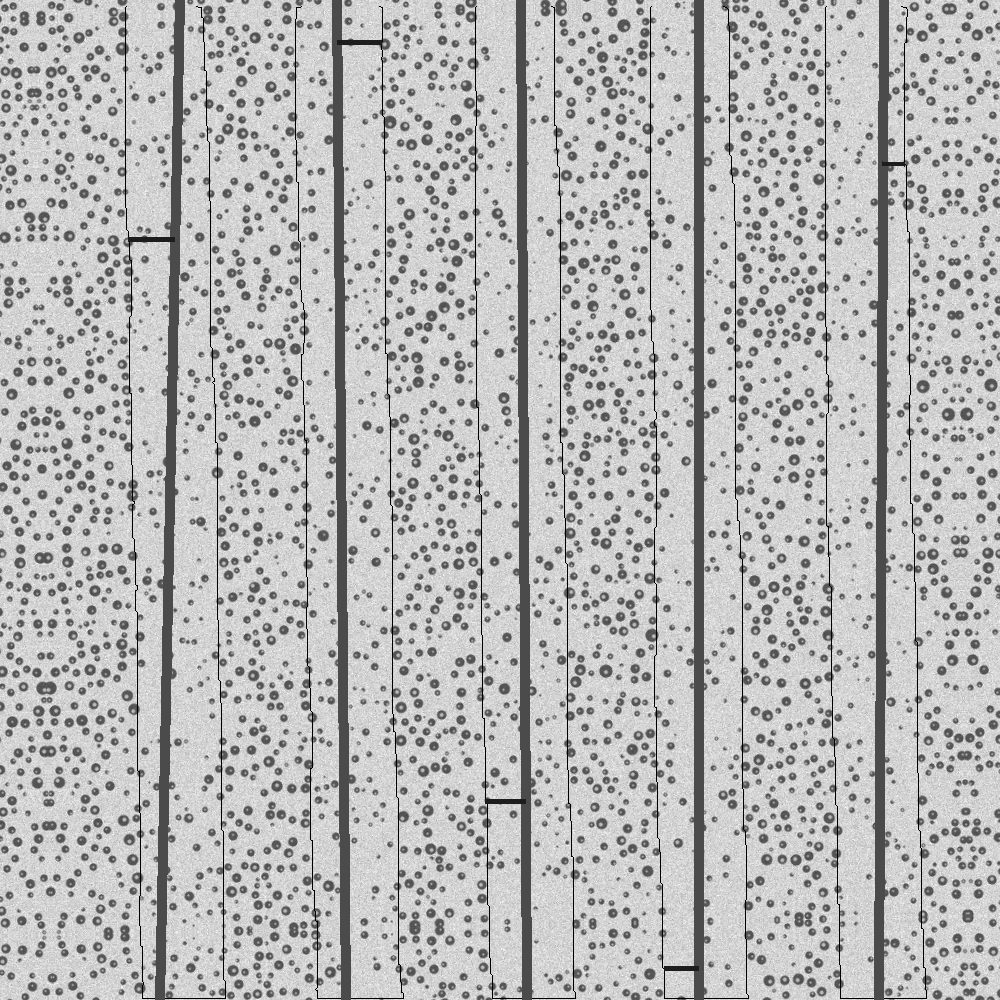

In [32]:
from utils.computation import calculate_widths, get_image_widths_by_path_names, draw_kernels
#model = YOLO('runs/segment/augmented_orig+supps_large_640_100epochs/weights/best.pt')
img_path = 'datasets/CF_simulation/images/augmented/val/01_line_Radius4_3_Density2000_1000_Width90_Reflection_1.tif'
#img_path = 'datasets/CF_simulation/images/augmented/val/01_line_Radius4_2_Density1500_1000_Width50_Reflection_1.tif'

#inference_results = model(source='datasets/CF_simulation/images/val2/', save=True, project='validation_test', conf=0.70)
inference_results = model(source=img_path, save=False, project='validation_test', conf=0.70)
calculate_widths(inference_results)
draw_kernels(inference_results, img_path)

In [46]:
Image.open(inference_results[0].path).size
filename =os.path.splitext(os.path.split(inference_results[1].path)[-1])[0]
#print((filename[39:42]))
from utils.computation import draw_kernels
draw_kernels(inference_results[16], 'D:/xie/Vision/mcp_yolo/validation_test/predict/05_sin_Radius5_3_Density1500_2000_Width60_Reflection_1_Curve1to7.tif')

(2, 28)
Elapsed time: 1.00017e-03
20.376413794374482
(2, 44)
Elapsed time: 0.00000e+00
14.546851061887951
(2, 29)
Elapsed time: 9.99451e-04
42.58093342966989
(2, 43)
Elapsed time: 0.00000e+00
38.66231381559961
(2, 28)
Elapsed time: 0.00000e+00
33.12822906692509
(2, 26)
Elapsed time: 0.00000e+00
22.96969935758081


In [8]:
import matplotlib.pyplot as plt
import time
#img = cv2.imread('datasets/CF_simulation/real_image/test/hdt5_0010.tif')
#img = Image.open('real_image_test/real_image_test/hdt5_1482.tif') 
img = Image.open('real_image_test/real_image_test7/01_line_Radius5_2_Density2000_2000_Width60_Reflection_0.tif') 
img = Image.open('datasets/CF_simulation/real_image/test_gs/0006.tif')
draw = ImageDraw.Draw(img) 
w, h = img.size

from utils.computation import calculate_widths, get_image_widths_by_path_names
predicted_widths = calculate_widths(inference_results=inference_results)
true_widths = get_image_widths_by_path_names(inference_results=inference_results)
print(predicted_widths.shape, true_widths.shape)
#filename =os.path.splitext(os.path.split(inference_results[1].path)[-1])[0]
#print(int(filename[40:42]))
#print(filename[40:].find('_'))
#print([inference_results[i].path for i in range(len(inference_results))])
#plt.imshow(img)
#plt.show()

(2, 160) (160,)
(2, 342) (342,)
(2, 402) (402,)
(2, 223) (223,)
(2, 539) (539,)
(2, 335) (335,)
(2, 368) (368,)
(2, 489) (489,)
(2, 117) (117,)
(2, 98) (98,)
(2, 470) (470,)
(2, 781) (781,)
(2, 702) (702,)
(2, 842) (842,)
(2, 502) (502,)
(2, 335) (335,)
(2, 54) (54,)
(2, 28) (28,)
(2, 27) (27,)
(2, 17) (17,)
(2, 32) (32,)


ValueError: invalid literal for int() with base 10: ''

In [ ]:
print(predicted_widths[:10], true_widths[:10])

In [151]:
# metrics 
errors = abs(predicted_widths - true_widths)/predicted_widths
np.quantile(errors, (0.1, 0.99))
errors.mean()

0.07550429134089048

(array([        201,         159,         123,          77,          39,          12,           4,           3,           3,           1]),
 array([ 0.00041019,    0.038447,    0.076484,     0.11452,     0.15256,     0.19059,     0.22863,     0.26667,     0.30471,     0.34274,     0.38078]),
 <BarContainer object of 10 artists>)

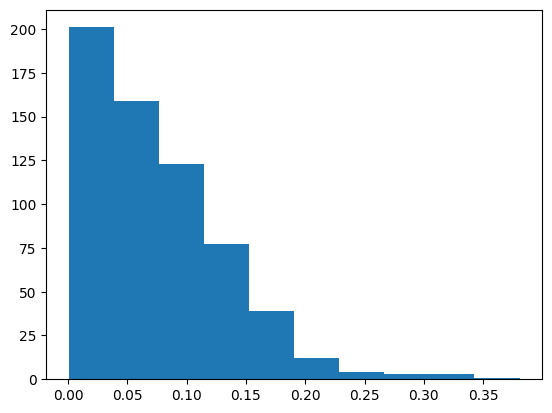

In [162]:
plt.hist(errors)

In [11]:
img = Image.open('real_image_test/real_image_test7/01_line_Radius5_2_Density2000_2000_Width60_Reflection_0.tif')
mask = Image.new("RGB", img.size, "black")  


for coos in inference_results[0].masks.xy:
    polygons = ImageDraw.Draw(mask)
    polygons.polygon(coos, fill='white')
    # calculate the individual width
    temp_mask = Image.new("RGB", img.size, "black")
    temp = ImageDraw.Draw(temp_mask)  
    temp.polygon(coos, fill='white')
    temp_mask = temp_mask.convert('1')
    #temp_mask.show()
    temp_mask = np.array(temp_mask)
    
    scanned_heights=np.array([])
    for col in temp_mask.T:
        col_sum = col.sum()
        if col_sum:
            scanned_heights = np.append(scanned_heights,col.sum())
    #print("{:.6f}".format(np.quantile(scanned_heights, 0.5, method='median_unbiased')/2**.5/temp_mask.shape[-1]))
    #print(scanned_heights.max()/2**.5)
#mask.show()
mask = mask.convert('1')
#mask.show()
mask = np.array(mask)
scanned_heights=np.array([])
for col in mask.T:
    col_sum = col.sum()
    if col_sum:
        scanned_heights = np.append(scanned_heights,col.sum())
print("{:.6f}".format(np.quantile(scanned_heights, 0.5, method='median_unbiased')/2**.5/temp_mask.shape[-1]))
mask_matrix = np.array(mask)

0.106066


In [ ]:
# validate model
model = YOLO('runs/segment/largedata_20epochs_480p_nano/weights/best.pt')
model.val(data='val.yaml', task='detect')

In [ ]:
import PIL.ImageOps as ImageOps
#test_result = model('datasets/CF_simulation/images/IMG10_sin_Radius7_4_Density1500_1000_Width50_Reflection_0_Curve1to20.tif')
#print(test_result)
#print(test_result[0].boxes)
model = YOLO('runs/segment/train/weights/best.pt')
test_img_path = 'datasets/CF_simulation/images/IMG10_sin_Radius7_4_Density1500_1000_Width50_Reflection_0_Curve1to20.tif'
test_result = model.predict(test_img_path, show=True, boxes=False)
#res_plotted = test_result[0].plot()
#print(test_result[0].boxes)
#cv2.imshow("result", res_plotted)
mask_seg = test_result[0].masks.data
print(mask_seg.data.shape)
#img = Image.open(test_img_path)
#mask = Image.fromarray(np.uint8(255*mask))
#seg_img = Image.fromarray(np.uint8(mask_seg.data.numpy()[0]))
#seg_img.show()
#img1 = img.paste(seg_img, (0, 0), seg_img)
#img = Image.fromarray(res_plotted)
#img1.show()
import torchvision.transforms as T
im = np.array(Image.new('RGB', (640, 640), (0,0,0)))
for seg in mask_seg:
    current = T.ToPILImage()(seg).convert('RGB')
    #current = ImageOps.invert(current)
    current = np.array(current)
    print(current)
    im += current
    #im.paste(current)
im = Image.fromarray(im)
#im = ImageOps.invert(im)
im.show()

In [80]:
import torch
torch.cuda.empty_cache()

In [11]:
import os
dir_path = 'D:\\xie\\simulationdroplet\\dataset\\supp3\\mask'
#dir_path = 'D:\\xie\\Vision\\mcp_yolo\\datasets\\CF_simulation\\images\\supp3'
#dir_path = 'dataset/CF_simulation/images/supp1'
for filename in os.listdir(dir_path):
    #break
    #os.rename(os.path.join(dir_path, filename), os.path.join(dir_path, filename[4:]))
    continue
    if filename.find('Width20') != -1:
        #continue
        os.rename(os.path.join(dir_path, filename), os.path.join(dir_path, 'supp1_'+filename))
        #os.remove(os.path.join(dir_path, filename))
#print(l)